<a href="https://colab.research.google.com/github/mc-ivan/data-mining-final-lab/blob/main/notebook/DataMiningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

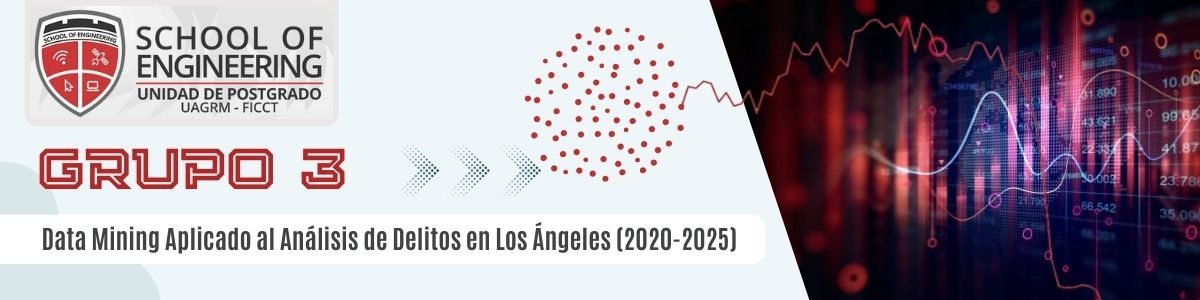

# Data Mining Aplicado al Análisis de Delitos en Los Ángeles (2020–2025)

## GRUPO 3:
- Karen Torrico
- Karen Huacota
- Yesika Luna
- Elvis Miranda
- Iván Mamani
---

### Objetivo del Proyecto

Analizar el comportamiento de los delitos reportados en Los Ángeles desde 2020 y predecir si un crimen será violento o no, usando variables disponibles en el dataset.

### Preguntas clave

- ¿Qué tipos de delitos son más frecuentes?
- ¿Hay patrones temporales o geográficos en los crímenes violentos?
- ¿Podemos predecir si un crimen es violento usando variables como ubicación, hora y tipo?

### Datos Técnicos

- **Fuente de Dataset:** [Crime Data from 2020 to Present - Data.gov](https://catalog.data.gov/dataset/crime-data-from-2020-to-present)

- **Dataset Aplicado:** [Crime Data from 2020 to Present - Comprimido](https://github.com/mc-ivan/data-mining-final-lab/blob/main/dataset/Crime_Data_from_2020_to_Present.csv.gz)

- **README:** [Resumen del Proyecto](https://github.com/mc-ivan/data-mining-final-lab/blob/main/README.md)

- **Informe de Proyecto:** [Documento explicado con interpretaciones](https://github.com/mc-ivan/data-mining-final-lab/blob/main/resources/Data%20Mining%20-%20Informe%20Final%20-%20Grupo%203.pdf)

- **Slides:** [Presentaciones](https://github.com/mc-ivan/data-mining-final-lab/blob/main/resources/Analisis_de_Delitos_en_Los_Angeles_(2020-2025).pdf)


# Implementacion

In [1]:
# ============================================
# 0. IMPORTS & CONFIG
# ============================================
# Standard library imports
import io, json, math, os, warnings
warnings.filterwarnings("ignore")

# MANEJO DE DATOS Y NÚMEROS
import numpy as np      # Operaciones matemáticas y arrays multidimensionales
import pandas as pd     # Manipulación y análisis de datos (DataFrames)

# VISUALIZACIÓN
import matplotlib.pyplot as plt         # Gráficos en 2D
from matplotlib.colors import LinearSegmentedColormap, ListedColormap # Colormaps personalizados
import matplotlib.patches as mpatches   # Crear leyendas y formas en gráficos
import seaborn as sns                   # Gráficos estadísticos de alto nivel

# UTILIDADES Y FECHAS
from datetime import datetime           # Manejo de fechas y tiempos
from urllib.request import urlopen      # Descargar datos desde URLs

# MACHINE LEARNING Y ESTADÍSTICA (SKLEARN)
from sklearn.model_selection import train_test_split   # Dividir dataset en train/test
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Codificación y normalización
from sklearn.compose import ColumnTransformer         # Transformaciones por columnas
from sklearn.pipeline import Pipeline                 # Encadenar pasos ML
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay, ConfusionMatrixDisplay, mean_squared_error
)                                                     # Métricas de evaluación

# Modelos clásicos
from sklearn.linear_model import LogisticRegression   # Regresión logística
from sklearn.ensemble import RandomForestClassifier, IsolationForest
# - RandomForestClassifier: Clasificación con bosques aleatorios
# - IsolationForest: Detección de anomalías

from sklearn.cluster import KMeans                    # Algoritmo de clustering
from sklearn.decomposition import PCA                 # Reducción de dimensionalidad

# ESTADÍSTICA AVANZADA (STATSMODELS)
import statsmodels.api as sm                          # Modelos estadísticos generales
from statsmodels.api import Logit, add_constant       # Modelos de regresión logística
from statsmodels.tools import add_constant            # Añadir constante en regresiones
from statsmodels.discrete.discrete_model import Logit # Otra forma de usar regresión logística
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# Rutas y parámetros
RAW_URL = "https://raw.githubusercontent.com/mc-ivan/data-mining-final-lab/main/dataset/Crime_Data_from_2020_to_Present.csv.gz"
OUT = "outputs_crime_project"
os.makedirs(OUT, exist_ok=True)

RANDOM_STATE = 42
ROW_SAMPLE = None
TOP_N_CATS = 25

# Paleta corporativa (teal y variantes)
# BRAND_COLORS = {
#     "primary": "#20B2AA",   # teal
#     "light": "#20B2AA",     # light teal
#     "dark": "#006666",      # dark teal
#     "accent": "#008080"     # cadet teal
# }

# Paleta corporativa (Rojo en relacion al crimen)
BRAND_COLORS = {
    "primary": "#B22222",  # Firebrick / rojo sangre
    "accent":  "#8B0000",  # Rojo oscuro / violencia
    "dark":    "#003153",  # Prussian Blue (clásico azul profundo, elegante, no negro)
    "light":   "#A52A2A",  # Brownish Red / Rojo ladrillo
}

# Configuración por defecto para todos los gráficos
DEFAULT_STYLE = {
    "figsize": (12, 6),

    # Estilo general
    "title_color": BRAND_COLORS["accent"],
    "axis_color": BRAND_COLORS["dark"],

    # Etiquetas
    "label_rotation": 0,           # rotación de etiquetas en eje x
    "xlabels_visible": False,      # ocultar etiquetas en eje X
    "ylabels_visible": False,      # ocultar etiquetas en eje Y

    # Valores sobre los elementos
    "show_values": False,
    "value_rotation": 0,
    "value_color": BRAND_COLORS["light"],
    "value_inside": False,

    # Ejes
    "hide_axes": True,            # ocultar eje completamente

    # Barplot
    "bar_orientation": "vertical",  # solo aplica si es barplot
    "bar_color": BRAND_COLORS["primary"],  # color teal normal
    "edge_color": "white",
}

In [3]:
# ============================
# Helpers de visualización
# ============================
def savefig(name):
    path = os.path.join(OUT, name)
    plt.savefig(path, bbox_inches="tight", dpi=140)
    print(f"[fig] {path}")

def bar_from_series(series, title, xlabel, ylabel, style=None):
    style = {**DEFAULT_STYLE, **(style or {})}  # Unificar estilos (default + custom)

    # Crear figura y ejes
    fig, ax = plt.subplots(figsize=style["figsize"])

    # Asignar colores (resaltar máximo valor si corresponde)
    highlight = style.get("highlight_max", False)  # activar con flag
    if highlight:
        max_val = series.max()
        colors = [
            BRAND_COLORS["primary"] if val == max_val else "#CAD0D6"
            for val in series.values
        ]
    else:
        colors = style["bar_color"]

    # Graficar barras (vertical u horizontal)
    if style["bar_orientation"] == "vertical":
        bars = ax.bar(series.index, series.values, color=colors, edgecolor=style["edge_color"])
    else:
        bars = ax.barh(series.index, series.values, color=colors, edgecolor=style["edge_color"])

    # Configurar título y etiquetas de ejes
    ax.set_title(title, color=style["title_color"], fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel, color=style["axis_color"])
    ax.set_ylabel(ylabel, color=style["axis_color"])

    # Formato de etiquetas del eje X
    plt.setp(ax.get_xticklabels(), rotation=style.get("label_rotation", 0), ha="right")

    # Estilo de ticks y bordes de los ejes
    ax.tick_params(colors=style["axis_color"])
    for spine in ax.spines.values():
        spine.set_color(style["axis_color"])

    # Ocultar ejes completos
    if style["hide_axes"]:
        for spine in ["top", "right", "left", "bottom"]:
            ax.spines[spine].set_visible(False)
        ax.tick_params(left=False, bottom=False)

    # Ocultar etiquetas de ejes
    if not style.get("xlabels_visible", True):
        ax.set_xticklabels([])
        ax.set_xlabel("")
    if not style.get("ylabels_visible", True):
        ax.set_yticklabels([])
        ax.set_ylabel("")

    # Mostrar valores sobre las barras
    if style["show_values"]:
        for bar in bars:
            if style["bar_orientation"] == "vertical":
                height = bar.get_height()
                if style.get("value_inside", False):
                    # Valor dentro de la barra
                    ax.annotate(
                        str(int(height)),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, -5),
                        textcoords="offset points",
                        ha="center",
                        va="top",
                        rotation=style.get("value_rotation", 0),
                        color="white",
                    )
                else:
                    # Valor encima de la barra
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        height,
                        str(int(height)),
                        ha="center",
                        va="bottom",
                        rotation=style.get("value_rotation", 0),
                        color=style.get("value_color", BRAND_COLORS["dark"]),
                    )
            else:
                width = bar.get_width()
                if style.get("value_inside", False):
                    # Valor dentro de la barra horizontal
                    ax.annotate(
                        f"{width:.2f}",
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(-5, 0),
                        textcoords="offset points",
                        ha="right",
                        va="center",
                        rotation=style.get("value_rotation", 0),
                        color="white",
                    )
                else:
                    # Valor al final de la barra horizontal
                    ax.text(
                        width,
                        bar.get_y() + bar.get_height() / 2,
                        f"{width:.2f}",
                        ha="left",
                        va="center",
                        rotation=style.get("value_rotation", 0),
                        color=style.get("value_color", BRAND_COLORS["dark"]),
                    )

    # Ajustar diseño
    plt.tight_layout()

def line_from_series(series, title, xlabel, ylabel, style=None, annotate=None):
    style = {**DEFAULT_STYLE, **(style or {})}  # merge defaults + custom

    # Crear figura
    fig, ax = plt.subplots(figsize=style["figsize"])

    # Graficar línea
    ax.plot(
        series.index, series.values,
        color=style.get("line_color", BRAND_COLORS["primary"]),
        linewidth=style.get("line_width", 1.5),
        marker=style.get("marker", None),
        markerfacecolor=style.get("marker_facecolor", BRAND_COLORS["accent"]),
        markeredgecolor=style.get("marker_edgecolor", "white")
    )
    ax.margins(x=0)

    # Configurar título
    ax.set_title(title, color=style["title_color"], fontsize=14, fontweight="bold")

    # Ejes (labels)
    ax.set_xlabel(xlabel, color=style["axis_color"])
    ax.set_ylabel(ylabel, color=style["axis_color"])

    # Estilo ticks
    ax.tick_params(colors=style["axis_color"])
    for spine in ax.spines.values():
        spine.set_color(style["axis_color"])

    # Ocultar ejes completos
    if style.get("hide_axes", True):
        for spine in ["top", "right", "left", "bottom"]:
            ax.spines[spine].set_visible(False)
        ax.tick_params(left=False, bottom=False)

    # Ocultar etiquetas
    if not style.get("xlabels_visible", True):
        ax.set_xticklabels([])
        ax.set_xlabel("")
    if not style.get("ylabels_visible", True):
        ax.set_yticklabels([])
        ax.set_ylabel("")

    # Grilla (si el usuario la quiere visible)
    if style.get("show_grid", False):
        ax.grid(
            visible=True,
            which="major",
            linestyle=style.get("grid_linestyle", ":"),
            linewidth=style.get("grid_linewidth", 0.8),
            color=style.get("grid_color", "#D3D3D3"),
            alpha=style.get("grid_alpha", 0.7)
        )

    # Anotación (para indicar codos)
    if annotate:
        ax.annotate(
            annotate.get("text", ""),
            xy=annotate["xy"],
            xytext=annotate.get("xytext", (annotate["xy"][0]+1, annotate["xy"][1]+5000)),
            arrowprops=dict(
                facecolor=annotate.get("color", BRAND_COLORS["primary"]),
                shrink=0.05,
                width=1,
                headwidth=8
            ),
            color=annotate.get("color", BRAND_COLORS["primary"]),
            fontsize=12,
            fontweight="bold"
        )

    plt.tight_layout()

def heatmap_corr(df, title):
    corr = df.corr(numeric_only=True)

    # Crear colormap con tus colores
    cmap = LinearSegmentedColormap.from_list(
        "brand_cmap", [BRAND_COLORS["accent"], "#FFFFFF", BRAND_COLORS["dark"]], N=256
    )

    plt.figure(figsize=(9,7))
    im = plt.imshow(corr, aspect='auto', cmap=cmap, vmin=-1, vmax=1)

    # Barra de colores
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(color=BRAND_COLORS["dark"], labelcolor=BRAND_COLORS["dark"])

    # Etiquetas
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, color=BRAND_COLORS["dark"])
    plt.yticks(range(len(corr.columns)), corr.columns, color=BRAND_COLORS["dark"])

    # Configurar título
    plt.title(title, color=DEFAULT_STYLE["title_color"], fontsize=14, fontweight="bold")

    # Bordes claros para separar celdas
    plt.grid(False)

    plt.tight_layout()

def plot_custom_corr(ts, kind="acf", lags=40, title="Correlation Plot"):
    fig, ax = plt.subplots(figsize=(10, 4))

    # Seleccionar tipo de Función de Autocorrelación y Función de Autocorrelación Parcial
    if kind == "acf":
        plot_acf(ts, lags=lags, ax=ax)
    elif kind == "pacf":
        plot_pacf(ts, lags=lags, ax=ax)
    else:
        raise ValueError("El parámetro kind debe ser 'acf' o 'pacf'")

    # Personalizar título y ejes
    ax.set_title(title, color=BRAND_COLORS["accent"], fontsize=14, fontweight="bold")
    ax.tick_params(axis='x', colors=BRAND_COLORS["dark"])
    ax.tick_params(axis='y', colors=BRAND_COLORS["dark"])

    # Cambiar color de los bordes
    for spine in ax.spines.values():
        spine.set_color(BRAND_COLORS["dark"])

    # Cambiar color de las barras (vienen como collections en el eje)
    for coll in ax.collections:
        coll.set_edgecolor(BRAND_COLORS["primary"])
        coll.set_facecolor(BRAND_COLORS["primary"])

    # Cambiar color de la línea de confianza
    for line in ax.lines:
        line.set_color(BRAND_COLORS["dark"])

    plt.tight_layout()

def roc_plot_from_predictions(y_true, y_proba, title="ROC Curve", style=None):
    style = {**DEFAULT_STYLE, **(style or {})}

    # Crear figura y eje
    fig, ax = plt.subplots(figsize=style.get("figsize", (7,5)))

    # Dibujar ROC
    RocCurveDisplay.from_predictions(y_true, y_proba, ax=ax, color=style.get("line_color", BRAND_COLORS["primary"]))

    # Personalizar título y ejes
    ax.set_title(title, color=style.get("title_color", BRAND_COLORS["accent"]), fontsize=14, fontweight="bold")
    ax.set_xlabel("False Positive Rate", color=style.get("axis_color", BRAND_COLORS["dark"]))
    ax.set_ylabel("True Positive Rate", color=style.get("axis_color", BRAND_COLORS["dark"]))

    # Línea diagonal de referencia
    ax.plot([0, 1], [0, 1], color=style.get("diag_color", BRAND_COLORS["light"]), linestyle="--")

    # Ticks y bordes
    ax.tick_params(colors=style.get("axis_color", BRAND_COLORS["dark"]))
    for spine in ax.spines.values():
        spine.set_color(style.get("axis_color", BRAND_COLORS["dark"]))

    plt.tight_layout()

def top_n_or_other(series, n=20, other="Other"):
    vc = series.value_counts()
    keep = set(vc.index[:n])
    return series.apply(lambda x: x if x in keep else other)


In [4]:
# ============================================
# 1. CARGA & ENTENDIMIENTO DE DATASET
# ============================================
print(">> Cargando dataset desde GitHub (gzip)...")
with urlopen(RAW_URL) as resp:
    raw = resp.read()
buf = io.BytesIO(raw)
df = pd.read_csv(buf, compression='gzip', low_memory=False, nrows=ROW_SAMPLE)

print(f"Dataset cargado con {df.shape[0]:,} filas y {df.shape[1]} columnas")
df.head()

>> Cargando dataset desde GitHub (gzip)...
Dataset cargado con 1,004,991 filas y 28 columnas


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,211507896,04/11/2021 12:00:00 AM,11/07/2020 12:00:00 AM,845,15,N Hollywood,1502,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,7800 BEEMAN AV,NaN,34.2124,-118.4092
1,201516622,10/21/2020 12:00:00 AM,10/18/2020 12:00:00 AM,1845,15,N Hollywood,1521,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",...,IC,Invest Cont,230.0,NaN,NaN,NaN,ATOLL AV,N GAULT,34.1993,-118.4203
2,240913563,12/10/2024 12:00:00 AM,10/30/2020 12:00:00 AM,1240,9,Van Nuys,933,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,14600 SYLVAN ST,NaN,34.1847,-118.4509
3,210704711,12/24/2020 12:00:00 AM,12/24/2020 12:00:00 AM,1310,7,Wilshire,782,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,NaN,NaN,NaN,6000 COMEY AV,NaN,34.0339,-118.3747
4,201418201,10/03/2020 12:00:00 AM,09/29/2020 12:00:00 AM,1830,14,Pacific,1454,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,4700 LA VILLA MARINA,NaN,33.9813,-118.4350


In [5]:
# Estándar de columnas (snake_case)
df.columns = (df.columns.str.strip().str.replace(r"[^0-9a-zA-Z]+", "_", regex=True).str.lower())

[fig] outputs_crime_project/01_nulls_top15.png


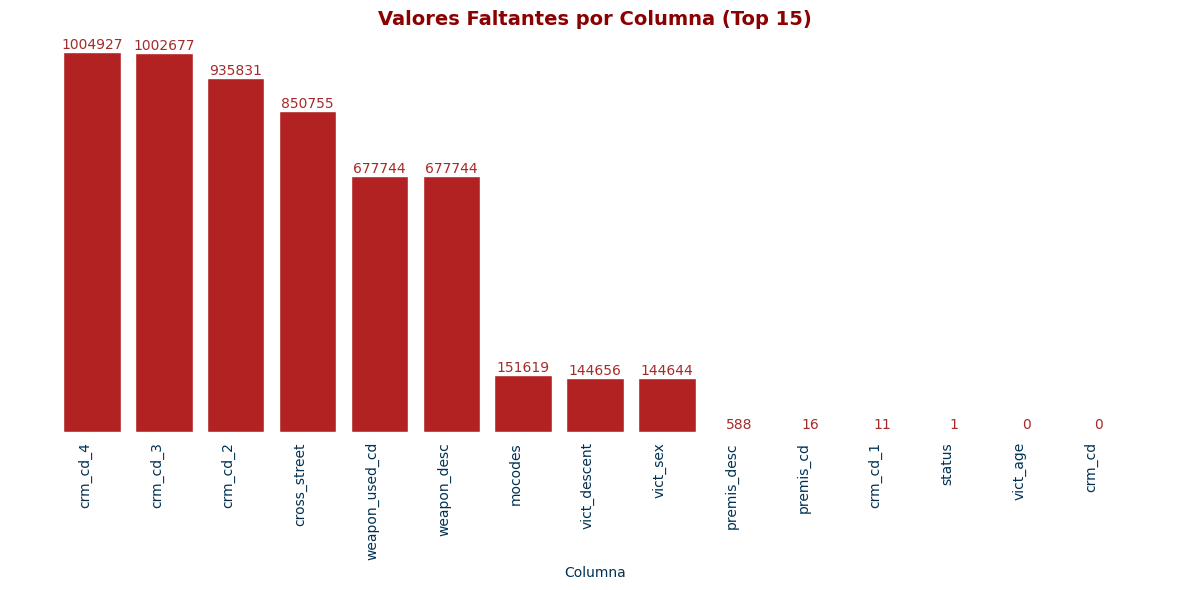

In [6]:
# Gráfico: valores nulos por columna (top 15)
nulls = df.isna().sum().sort_values(ascending=False)
bar_from_series(nulls.head(15), "Valores Faltantes por Columna (Top 15)", "Columna", "Nulos",
    style = {"bar_orientation": "vertical", "label_rotation": 90, "show_values": True, "value_rotation": "horizontal", "xlabels_visible": True}
)

savefig("01_nulls_top15.png"); plt.show(); plt.close()

In [7]:
# ============================================
# 2. PREPROCESAMIENTO DE DATOS
# ============================================

# 2.1 Parse de fechas frecuentes
print("ANTES (date_occ):")
print(df["date_occ"].head(5))   # preview antes del parseo

date_cols = [c for c in ["date_occ","date_rptd","date_reported","occ_date","date"] if c in df.columns]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

print("\nDESPUÉS (date_occ):")
print(df["date_occ"].head(5))
print(f"Columnas de fecha parseadas: {date_cols}")

ANTES (date_occ):
0    11/07/2020 12:00:00 AM
1    10/18/2020 12:00:00 AM
2    10/30/2020 12:00:00 AM
3    12/24/2020 12:00:00 AM
4    09/29/2020 12:00:00 AM
Name: date_occ, dtype: object

DESPUÉS (date_occ):
0   2020-11-07
1   2020-10-18
2   2020-10-30
3   2020-12-24
4   2020-09-29
Name: date_occ, dtype: datetime64[ns]
Columnas de fecha parseadas: ['date_occ', 'date_rptd']


In [8]:
# 2.2 Parse de hora: normalizamos la columna de tiempo y extraemos la hora en 'hour_occ'
print("\nANTES (time_occ):")
if "time_occ" in df.columns:
    print(df["time_occ"].head(5))

time_candidates = [c for c in ["time_occ","time","time_occurrence"] if c in df.columns]
if time_candidates:
    tcol = time_candidates[0]
    s = pd.to_numeric(df[tcol], errors="coerce").fillna(0).astype(int).astype(str).str.zfill(4)
    df["hour_occ"] = pd.to_numeric(s.str[:2], errors="coerce")
else:
    df["hour_occ"] = np.nan

print("\nDESPUÉS (hour_occ):")
print(df[["hour_occ"]].head(5))



ANTES (time_occ):
0     845
1    1845
2    1240
3    1310
4    1830
Name: time_occ, dtype: int64

DESPUÉS (hour_occ):
   hour_occ
0         8
1        18
2        12
3        13
4        18


In [9]:
# 2.3 Selección de fecha base: definimos una columna de referencia para análisis de tiempo
# Prioridad: date_occ > date_rptd > primera columna datetime > None
if "date_occ" in df.columns:
    date_base = "date_occ"
elif "date_rptd" in df.columns:
    date_base = "date_rptd"
else:
    dtcols = df.select_dtypes(include=["datetime64[ns]"]).columns
    date_base = dtcols[0] if len(dtcols) else None

print(f"\nFecha Base seleccionada: {date_base}")



Fecha Base seleccionada: date_occ


In [10]:
# 2.4 Feature engineering temporal
print("\nANTES: columnas")
print(df.columns)

# Si tenemos una columna base de fechas (date_base) vamos a extraer atributos temporales
if date_base:
    df["year"] = df[date_base].dt.year
    df["month"] = df[date_base].dt.month
    df["dayofweek"] = df[date_base].dt.dayofweek  # 0=Lunes
    df["date_month"] = df[date_base].dt.to_period("M").dt.to_timestamp()
else:
    # Si no hay columna base de fecha, se crean columnas con NaN como placeholder
    df["year"] = np.nan; df["month"]=np.nan; df["dayofweek"]=np.nan

print("\nDESPUÉS: preview de nuevas columnas")
print(df[["year","month","dayofweek","date_month"]].head(5))



ANTES: columnas
Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1_2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'location', 'cross_street', 'lat',
       'lon', 'hour_occ'],
      dtype='object')

DESPUÉS: preview de nuevas columnas
   year  month  dayofweek date_month
0  2020     11          5 2020-11-01
1  2020     10          6 2020-10-01
2  2020     10          4 2020-10-01
3  2020     12          3 2020-12-01
4  2020      9          1 2020-09-01


In [11]:
# 2.5 Limpieza de geocoordenadas
# Buscar columnas candidatas de latitud y longitud
lat_col = None
lon_col = None
for c in ["lat","latitude","latitute"]:  # LAPD: 'lat'
    if c in df.columns: lat_col = c; break
for c in ["lon","longitude","long","lng"]: # LAPD: 'lon'
    if c in df.columns: lon_col = c; break

print("\nANTES: Preview coordenadas")
if lat_col and lon_col:
    print(df[[lat_col, lon_col]].head(5))

if lat_col and lon_col:
    # Convertir a numérico
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    # Eliminar coordenadas inválidas: (0,0) o fuera del rango de Los Ángeles
    df.loc[(df[lat_col]==0) & (df[lon_col]==0), [lat_col, lon_col]] = np.nan
    df.loc[~df[lat_col].between(33.0, 35.5), lat_col] = np.nan
    df.loc[~df[lon_col].between(-119.5, -117.0), lon_col] = np.nan
    # Nueva feature: indicador de registros con coordenadas válidas
    df["has_geo"] = (~df[lat_col].isna()) & (~df[lon_col].isna())
else:
    df["has_geo"] = False

print("\nDESPUÉS: Preview coordenadas limpias + indicador")
if lat_col and lon_col:
    print(df[[lat_col, lon_col, "has_geo"]].head(5))
else:
    print(df[["has_geo"]].head(5))



ANTES: Preview coordenadas
       lat       lon
0  34.2124 -118.4092
1  34.1993 -118.4203
2  34.1847 -118.4509
3  34.0339 -118.3747
4  33.9813 -118.4350

DESPUÉS: Preview coordenadas limpias + indicador
       lat       lon  has_geo
0  34.2124 -118.4092     True
1  34.1993 -118.4203     True
2  34.1847 -118.4509     True
3  34.0339 -118.3747     True
4  33.9813 -118.4350     True


In [12]:
# 2.6 Limpiar y unificar columnas categóricas clave del dataset.
# Función auxiliar para copiar columna si no existe
def copy_if_missing(target, candidates):
    if target not in df.columns:
        for c in candidates:
            if c in df.columns:
                df[target] = df[c].astype(str).str.strip()
                return

print("\nANTES: columnas categóricas")
print([c for c in df.columns if "premis" in c or "area" in c or "crm" in c])

# Normalizamos nombres de columnas clave
copy_if_missing("premis_desc", ["premis_desc","premise","premise_desc","location_desc"])
copy_if_missing("area_name", ["area_name","area","division","district_name","reporting_district"])
copy_if_missing("crm_cd_desc", ["crm_cd_desc","crime_code_description","offense_description","offense"])

print("\nDESPUÉS: columnas categóricas unificadas")
print(df[["premis_desc","area_name","crm_cd_desc"]].head(5))


ANTES: columnas categóricas
['area', 'area_name', 'crm_cd', 'crm_cd_desc', 'premis_cd', 'premis_desc', 'crm_cd_1', 'crm_cd_2', 'crm_cd_3', 'crm_cd_4']

DESPUÉS: columnas categóricas unificadas
              premis_desc    area_name  \
0  SINGLE FAMILY DWELLING  N Hollywood   
1                SIDEWALK  N Hollywood   
2  SINGLE FAMILY DWELLING     Van Nuys   
3                  STREET     Wilshire   
4                   ALLEY      Pacific   

                                         crm_cd_desc  
0                                  THEFT OF IDENTITY  
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  
2                                  THEFT OF IDENTITY  
3  THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...  
4    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)  


In [13]:
# 2.7 Target: Violent Crime -> creamos la variable binaria para definir si un crimen es o no es violento
# Mostrar un ejemplo de la columna "crm_cd_desc" (descripción del crimen)
print("\nANTES: crm_cd_desc ejemplo")
if "crm_cd_desc" in df.columns:
    print(df["crm_cd_desc"].head(5))

if "crm_cd_desc" in df.columns:
    # Convertimos las descripciones de crimen a mayúsculas para normalizar
    d = df["crm_cd_desc"].astype(str).str.upper()
    # Lista de palabras clave asociadas a crímenes violentos
    violent_kw = ["HOMICIDE","MANSLAUGHTER","ROBBERY","ASSAULT","BATTERY","RAPE","SEXUAL","KIDNAPPING","ARSON","SHOOT","STAB"]
    # Creamos variable binaria: 1 = crimen violento, 0 = no violento
    df["violent_crime"] = d.apply(lambda t: int(any(k in t for k in violent_kw)))
else:
    df["violent_crime"] = np.nan

print("\nDESPUÉS: variable target 'violent_crime'")
print(df[["crm_cd_desc","violent_crime"]].head(5))


ANTES: crm_cd_desc ejemplo
0                                    THEFT OF IDENTITY
1       ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT
2                                    THEFT OF IDENTITY
3    THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...
4      THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
Name: crm_cd_desc, dtype: object

DESPUÉS: variable target 'violent_crime'
                                         crm_cd_desc  violent_crime
0                                  THEFT OF IDENTITY              0
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              1
2                                  THEFT OF IDENTITY              0
3  THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...              0
4    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              0



--- Limpieza: Columnas mínimas ---
Antes: 1004991 | Después: 1004991 | Eliminados: 0

--- Limpieza: Edades válidas (1-120) ---
Antes: 1004991 | Después: 735632 | Eliminados: 269359

--- Limpieza: Sexo válido ---
Antes: 735632 | Después: 735488 | Eliminados: 144

--- Limpieza: Raza válida ---
Antes: 735488 | Después: 718348 | Eliminados: 17140

--- Limpieza: Coordenadas válidas ---
Antes: 718348 | Después: 716689 | Eliminados: 1659

--- Limpieza: Fechas válidas ---
Antes: 716689 | Después: 716689 | Eliminados: 0
[fig] outputs_crime_project/02_rows_before_after.png


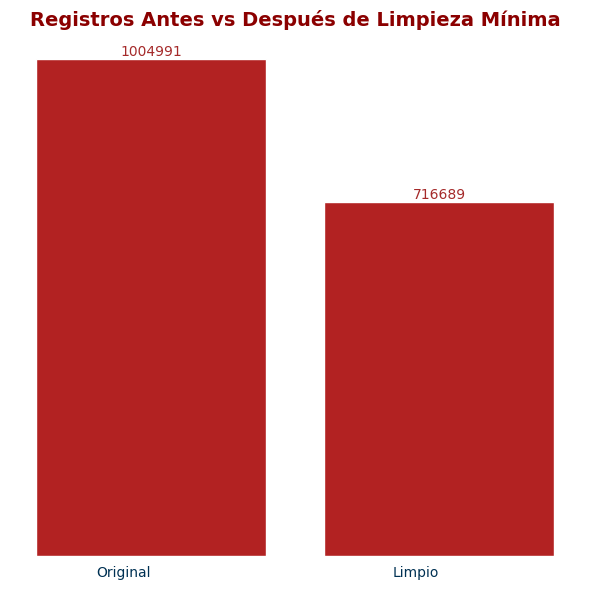

In [14]:
# 2.8. Limpieza de registros
# Copia inicial del dataset
df_clean = df.copy()

# 2.8.1. Filtrar por columnas mínimas requeridas
print("\n--- Limpieza: Columnas mínimas ---")
before = len(df_clean)
req_cols = [c for c in [date_base, "crm_cd_desc", "violent_crime"] if c]
df_clean = df_clean.dropna(subset=req_cols)
after = len(df_clean)
print(f"Antes: {before} | Después: {after} | Eliminados: {before - after}")

# 2.8.2. Filtrar edades válidas
print("\n--- Limpieza: Edades válidas (1-120) ---")
before = len(df_clean)
df_clean = df_clean[(df_clean["vict_age"].notna()) & (df_clean["vict_age"] > 0) & (df_clean["vict_age"] <= 120)]
after = len(df_clean)
print(f"Antes: {before} | Después: {after} | Eliminados: {before - after}")

# 2.8.3. Filtrar sexos válidos (M/F/X)
print("\n--- Limpieza: Sexo válido ---")
before = len(df_clean)
valid_sex = ["M", "F", "X"]
df_clean = df_clean[df_clean["vict_sex"].isin(valid_sex)]
after = len(df_clean)
print(f"Antes: {before} | Después: {after} | Eliminados: {before - after}")

# 2.8.4. Filtrar grupos raciales válidos (no vacíos ni 'X')
print("\n--- Limpieza: Raza válida ---")
before = len(df_clean)
df_clean = df_clean[df_clean["vict_descent"].notna() & (df_clean["vict_descent"] != "X")]
after = len(df_clean)
print(f"Antes: {before} | Después: {after} | Eliminados: {before - after}")

# 2.8.5. Filtrar coordenadas válidas (no nulas, no 0, dentro de LA aprox.)
print("\n--- Limpieza: Coordenadas válidas ---")
before = len(df_clean)
df_clean = df_clean[
    df_clean["lat"].notna() & df_clean["lon"].notna() &
    (df_clean["lat"] != 0) & (df_clean["lon"] != 0) &
    (df_clean["lat"].between(33, 35)) &  # rango LA
    (df_clean["lon"].between(-119, -117))
]
after = len(df_clean)
print(f"Antes: {before} | Después: {after} | Eliminados: {before - after}")

# 6) Filtrar fechas válidas (no nulas y posteriores a 2000)
print("\n--- Limpieza: Fechas válidas ---")
before = len(df_clean)
df_clean = df_clean[df_clean[date_base].notna() & (df_clean[date_base] >= "2000-01-01")]
after = len(df_clean)
print(f"Antes: {before} | Después: {after} | Eliminados: {before - after}")

# Gráfico final: comparativa total
data_series = pd.Series([len(df), len(df_clean)], index=["Original", "Limpio"])
bar_from_series(data_series, "Registros Antes vs Después de Limpieza Mínima", "", "Nº filas",
    style={"figsize": (6, 6), "show_values": True, "xlabels_visible": True}
)

savefig("02_rows_before_after.png"); plt.show(); plt.close()


[fig] outputs_crime_project/03_top_15_crime.png


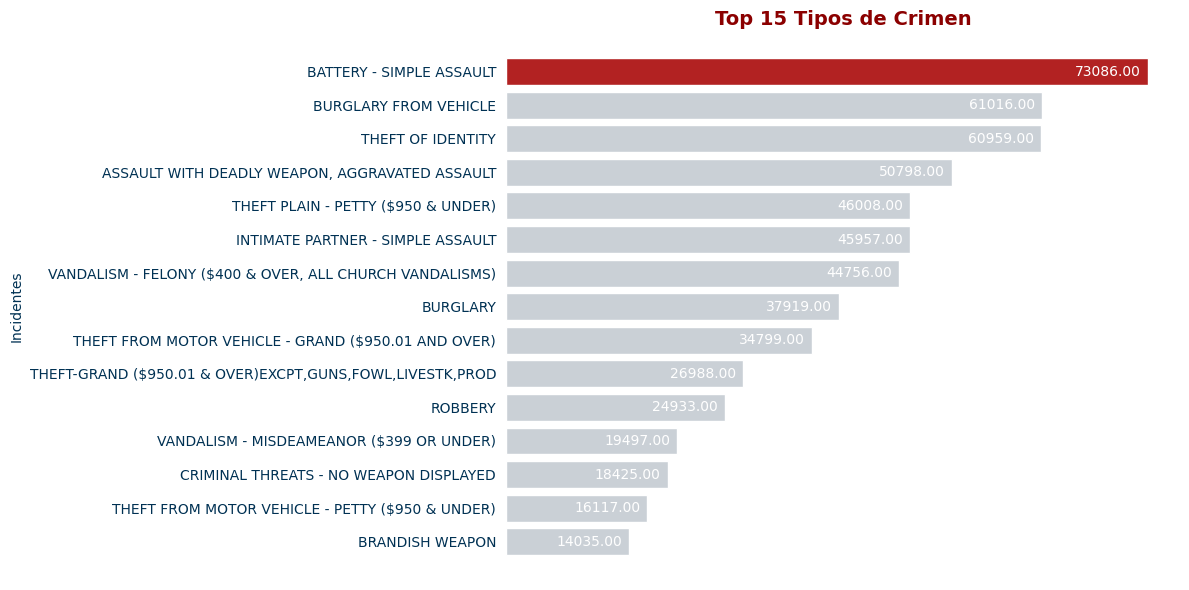

In [37]:
# ============================================
# 3. Análisis Exploratorio de Datos (EDA) DESCRIPTIVO (GRÁFICAS)
# ============================================
# 3.1 Top delitos
# column crm_cd_desc
top_crimes = df_clean["crm_cd_desc"].value_counts().head(15).sort_values()
bar_from_series(top_crimes, "Top 15 Tipos de Crimen", "Delito", "Incidentes",
    style={"bar_orientation": "horizontal", "show_values": True, "value_inside": True, "value_rotation": "horizontal", "ylabels_visible": True, "highlight_max": True}
)

savefig("03_top_15_crime.png"); plt.show(); plt.close()

[fig] outputs_crime_project/03_monthly_series.png


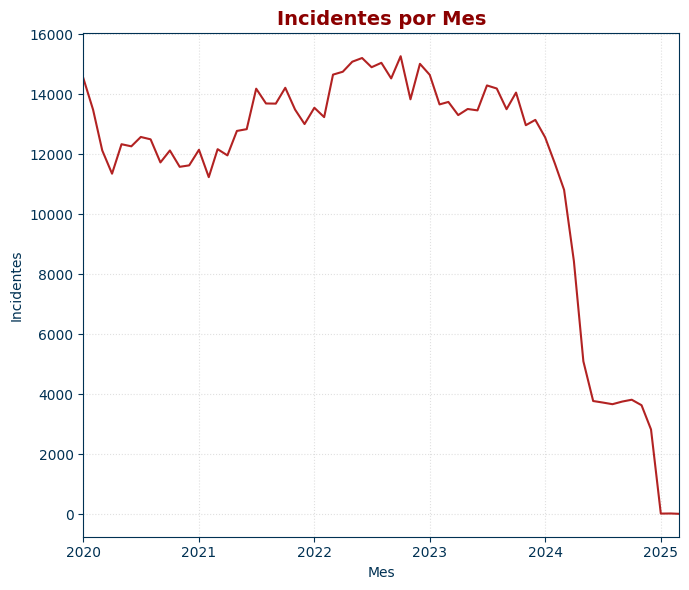

In [16]:
# 3.2 Tendencia mensual de incidentes
# Columna date_month
monthly = df_clean.groupby("date_month").size()
line_from_series(monthly, "Incidentes por Mes", "Mes", "Incidentes",
    style={"figsize": (7, 6), "hide_axes": False, "xlabels_visible": True, "ylabels_visible": True, "show_grid": True}
)

savefig("03_monthly_series.png"); plt.show(); plt.close()

[fig] outputs_crime_project/03_incidents_per_day_of_week.png


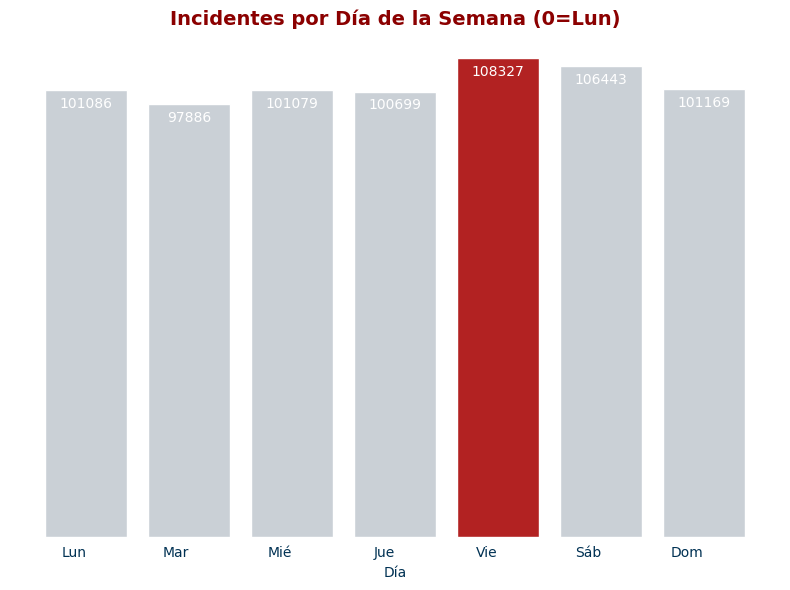

In [17]:
# 3.3 Distribución por día de semana
# Column dayofweek
# Conteo por día de la semana (0=Lun)
dow = df_clean["dayofweek"].value_counts().sort_index()
labels = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]

# Crear series con índices renombrados
dow_series = pd.Series(dow.values, index=labels[:len(dow)])

# Graficar con tu función
bar_from_series(dow_series, title="Incidentes por Día de la Semana (0=Lun)", xlabel="Día", ylabel="Incidentes",
    style={"figsize": (8, 6), "bar_orientation": "vertical", "show_values": True, "value_inside": True, "value_rotation": "horizontal", "xlabels_visible": True, "highlight_max": True}
)

savefig("03_incidents_per_day_of_week.png"); plt.show(); plt.close()


[fig] outputs_crime_project/03_victim_age_hist.png


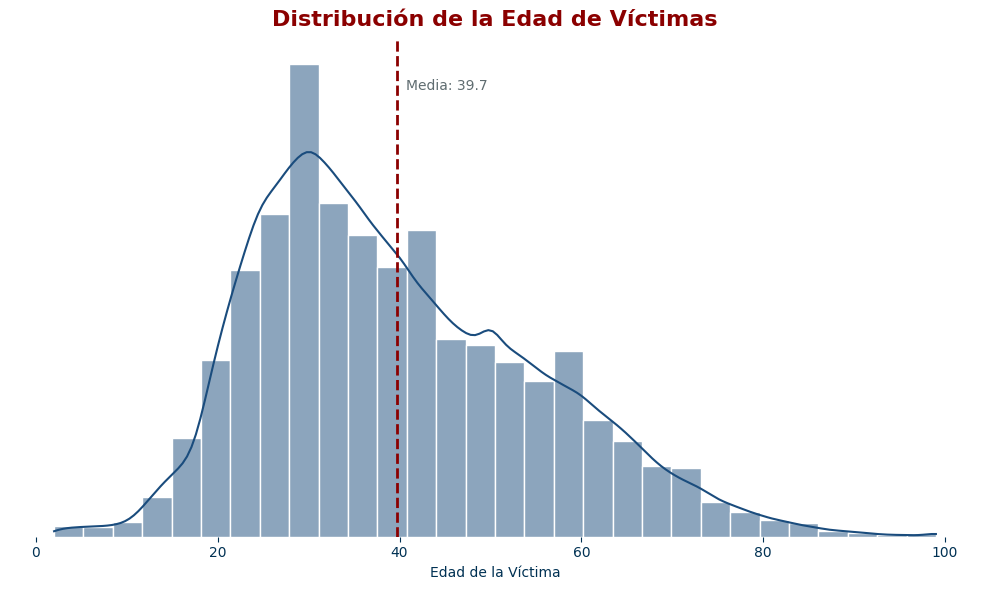

In [18]:
# 3.4 Hist edad de víctima (si existe)
# Column vict_age
plt.figure(figsize=(10, 6))

# Quitar marcas y texto del eje Y, pero mostrar etiquetas eje X
plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=False, labelbottom=True, colors=BRAND_COLORS["dark"])

# Quitar bordes del gráfico
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Histograma estilizado
sns.histplot(df_clean["vict_age"].dropna().astype(float), bins=30, kde=True, color="#1A4C7D", edgecolor="white")

# Título y etiquetas
plt.title("Distribución de la Edad de Víctimas", fontsize=16, fontweight="bold", color=BRAND_COLORS["accent"], pad=10)
plt.xlabel("Edad de la Víctima", color=BRAND_COLORS["dark"])

# Media de la edad
mean_age = df_clean["vict_age"].dropna().astype(float).mean()
plt.axvline(mean_age, color=BRAND_COLORS["accent"], linestyle="--", linewidth=2)
plt.text(mean_age+1, plt.ylim()[1]*0.9, f"Media: {mean_age:.1f}", color="#5F6C70")

plt.tight_layout()

savefig("03_victim_age_hist.png"); plt.show(); plt.close()


[fig] outputs_crime_project/03_corr_heatmap.png


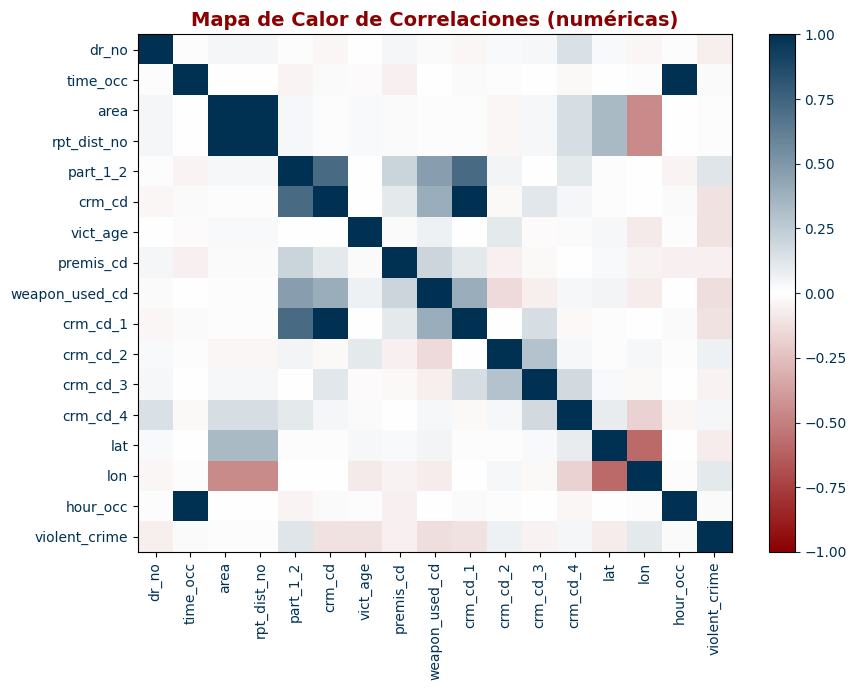

In [19]:
# 3.5 Correlaciones numéricas
num_df = df_clean.select_dtypes(include=["int64","float64"]).copy()
if not num_df.empty:
    heatmap_corr(num_df, "Mapa de Calor de Correlaciones (numéricas)")
    savefig("03_corr_heatmap.png"); plt.show(); plt.close()

In [20]:
# ============================================
# 4. MODELOS ESTADÍSTICOS
# ============================================
# 4.1 OLS: Regresión lineal sobre incidencias mensuales
#  Column date_month
# target: incidencias mensuales
mdf = df_clean.groupby(["date_month"]).size().rename("incidents").reset_index()

# features temporales simples
mdf["year"] = mdf["date_month"].dt.year
mdf["month"] = mdf["date_month"].dt.month
X = add_constant(mdf[["year","month"]])
y = mdf["incidents"]
ols_model = sm.OLS(y, X).fit()
print("\n[OLS] Resumen:")
print(ols_model.summary())



[OLS] Resumen:
                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     16.94
Date:                Fri, 22 Aug 2025   Prob (F-statistic):           1.47e-06
Time:                        17:52:16   Log-Likelihood:                -601.05
No. Observations:                  63   AIC:                             1208.
Df Residuals:                      60   BIC:                             1215.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.391e+06   5.82e+05    

[fig] outputs_crime_project/04_ols_obs_vs_pred.png


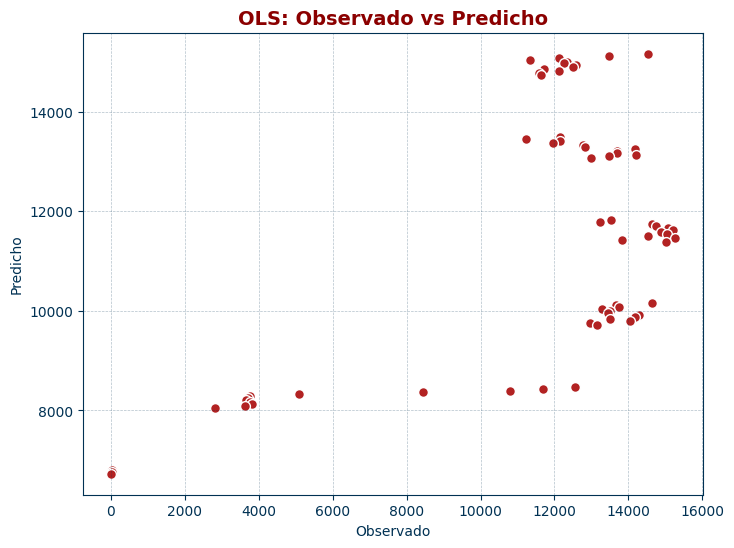

In [21]:
# Gráficos OLS: Ajustes
# Observado vs Predicho - OLS
y_hat = ols_model.predict(X)

plt.figure(figsize=(8,6))

# Scatter
plt.scatter(y, y_hat, s=50, c=BRAND_COLORS["primary"], edgecolors="white")

# Títulos y ejes
plt.title("OLS: Observado vs Predicho", color=BRAND_COLORS["accent"], fontsize=14, fontweight="bold")
plt.xlabel("Observado", color=BRAND_COLORS["dark"])
plt.ylabel("Predicho", color=BRAND_COLORS["dark"])

# Bordes y ticks de los ejes
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color(BRAND_COLORS["dark"])
ax.tick_params(colors=BRAND_COLORS["dark"])

# Grilla
plt.grid(True, color=BRAND_COLORS["dark"], linestyle="--", linewidth=0.5, alpha=0.3)

savefig("04_ols_obs_vs_pred.png"); plt.show(); plt.close()

[fig] outputs_crime_project/04_ols_residuals.png


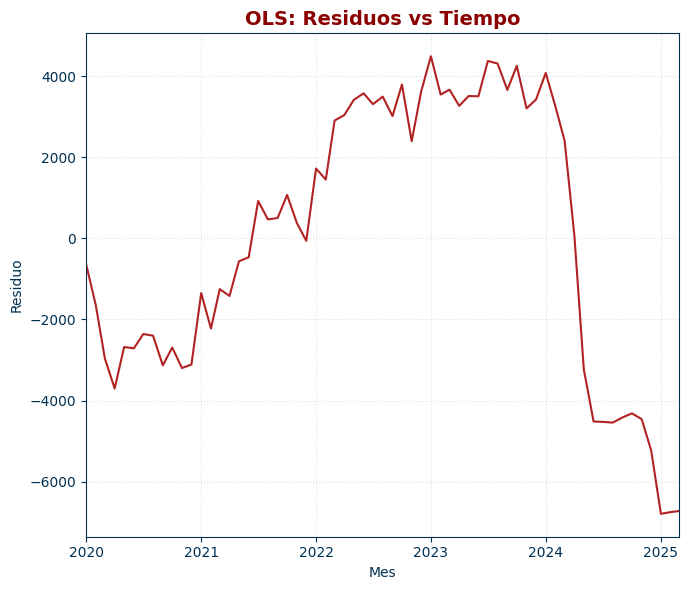

In [22]:
# Gráficos OLS: Residuos
residuals = y - y_hat
residuals_series = pd.Series(residuals.values, index=pd.to_datetime(mdf["date_month"]))

line_from_series(residuals_series, "OLS: Residuos vs Tiempo", "Mes", "Residuo",
    style={"figsize": (7, 6), "hide_axes": False, "xlabels_visible": True, "ylabels_visible": True, "show_grid": True}
)

savefig("04_ols_residuals.png"); plt.show(); plt.close()


[Logit] Coeficientes y OR:
                                                        coef        OR  \
premis_desc_top_SIDEWALK                            0.816005  2.261447   
const                                               0.402085  1.494938   
area_name_top_Southeast                             0.103444  1.108984   
dayofweek                                           0.037483  1.038194   
hour_occ                                            0.007551  1.007579   
month                                              -0.001302  0.998699   
premis_desc_top_PARK/PLAYGROUND                    -0.005294  0.994720   
premis_desc_top_HOTEL                              -0.007476  0.992552   
premis_desc_top_GAS STATION                        -0.015569  0.984551   
area_name_top_Newton                               -0.168000  0.845354   
premis_desc_top_RESTAURANT/FAST FOOD               -0.318516  0.727227   
area_name_top_Rampart                              -0.336758  0.714082   
area_name_

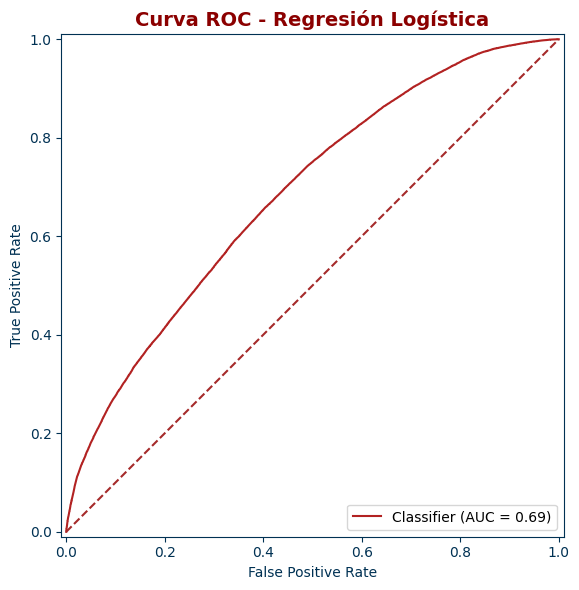

In [23]:
# 4.2 Regresión LOGÍSTICA (statsmodels) para Odds Ratios
# predict: violent_crime ~ hour_occ + dayofweek + month + area_name_top + premis_desc_top

# Copia del dataset limpio
work = df_clean.copy()

# Limpiar variables categóricas
for c in ["area_name","premis_desc","crm_cd_desc"]:
    if c in work.columns:
        work[c] = work[c].fillna("Unknown").astype(str).str.strip()

# Reducción de cardinalidad
if "violent_crime" in work.columns and work["violent_crime"].notna().any():
    for c, N in [("area_name", 18), ("premis_desc", 25), ("crm_cd_desc", 25)]:
        if c in work.columns:
            work[c+"_top"] = top_n_or_other(work[c], n=N)

    # Selección de features
    feats = [col for col in ["hour_occ","dayofweek","month","area_name_top","premis_desc_top"] if col in work.columns]
    logi = work.dropna(subset=["violent_crime"] + feats).copy()

    # Crear dummies y convertir a float
    X = pd.get_dummies(logi[feats], drop_first=True).astype(float)

    # Agregar constante para el intercepto
    X = add_constant(X)

    # Variable objetivo
    y = logi["violent_crime"].astype(int)

    # Ajustar modelo Logit
    logit_model = Logit(y, X).fit(disp=False)

    # Mostrar coeficientes y OR
    print("\n[Logit] Coeficientes y OR:")
    params = logit_model.params
    or_table = pd.DataFrame({
        "coef": params,
        "OR": np.exp(params),
        "pvalue": logit_model.pvalues
    }).sort_values("OR", ascending=False)
    print(or_table.head(20))

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    # Entrenar modelo
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

    # Obtener probabilidades de la clase positiva
    y_proba = clf.predict_proba(X_test)[:, 1]  # [:,1] toma la probabilidad de la clase 1

    # Graficar ROC
    roc_plot_from_predictions(y_test, y_proba, title="Curva ROC - Regresión Logística")
    savefig("04_reg_log_roc.png"); plt.show(); plt.close()


In [24]:
# ============================================
# 5. MACHINE LEARNING (Clasificación)
# ============================================
# Pipeline con OneHot + Standardize + RandomForest
features_num = [c for c in ["hour_occ","dayofweek","month","year"] if c in df_clean.columns]
features_cat = [c for c in ["area_name","premis_desc","crm_cd_desc"] if c in df_clean.columns]

ml = df_clean.dropna(subset=["violent_crime"]).copy()
for c in features_cat:
    if c in ml.columns:
        ml[c] = top_n_or_other(ml[c].astype(str), n=TOP_N_CATS)

X = ml[features_num + [c for c in features_cat if c in ml.columns]]
y = ml["violent_crime"].astype(int)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), [c for c in features_cat if c in ml.columns])
    ],
    remainder="drop"
)

rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
pipe = Pipeline([("prep", pre), ("rf", rf)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba),
}
print("\n[RandomForest] Métricas:")
print(json.dumps(metrics, indent=2))


[RandomForest] Métricas:
{
  "accuracy": 0.9673219941676318,
  "precision": 0.9648120367102012,
  "recall": 0.9340267395668703,
  "f1": 0.9491698317959848,
  "roc_auc": 0.9966567264270579
}


[fig] outputs_crime_project/05_rf_roc.png


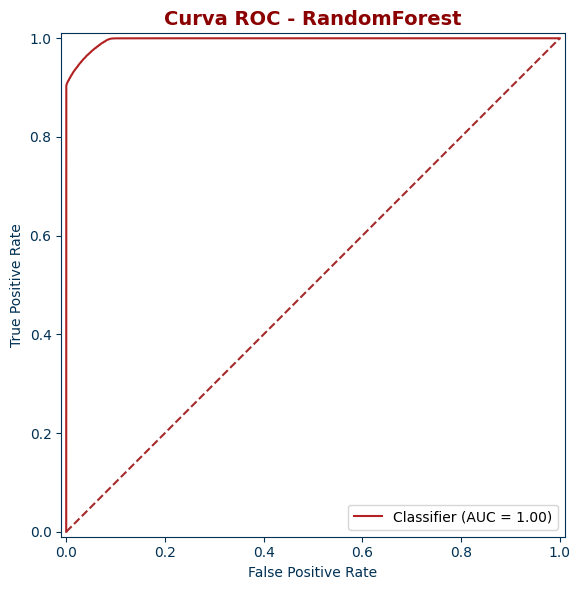

In [25]:
# Gráficos: curva ROC
roc_plot_from_predictions(y_test, y_proba, title="Curva ROC - RandomForest")
savefig("05_rf_roc.png"); plt.show(); plt.close()

[fig] outputs_crime_project/05_rf_cm.png


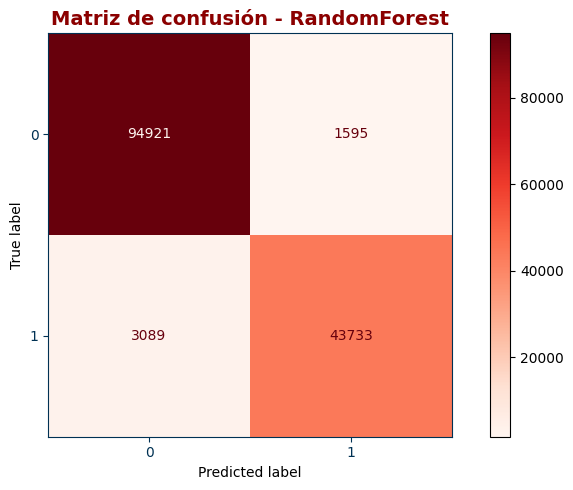

In [26]:
# Gráficos: Matriz de confusión
fig, ax = plt.subplots(figsize=(8, 5))

# Dibujar matriz de confusión
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap=plt.cm.Reds)

# Cambiar color de los cuadros
for im in ax.collections:
    im.set_cmap(plt.cm.get_cmap('Reds'))  # opcional si quieres degradado
    im.set_clim(0, disp.confusion_matrix.max())  # normalizar rango

# Título
ax.set_title("Matriz de confusión - RandomForest", color=BRAND_COLORS["accent"], fontsize=14, fontweight="bold")

# Ejes y bordes
ax.tick_params(colors=BRAND_COLORS["dark"])
for spine in ax.spines.values():
    spine.set_color(BRAND_COLORS["dark"])

# Etiquetas de filas y columnas (tick labels)
ax.set_xticklabels(disp.display_labels, color=BRAND_COLORS["dark"])
ax.set_yticklabels(disp.display_labels, color=BRAND_COLORS["dark"])

plt.tight_layout()

savefig("05_rf_cm.png"); plt.show(); plt.close()

[fig] outputs_crime_project/05_rf_importances.png


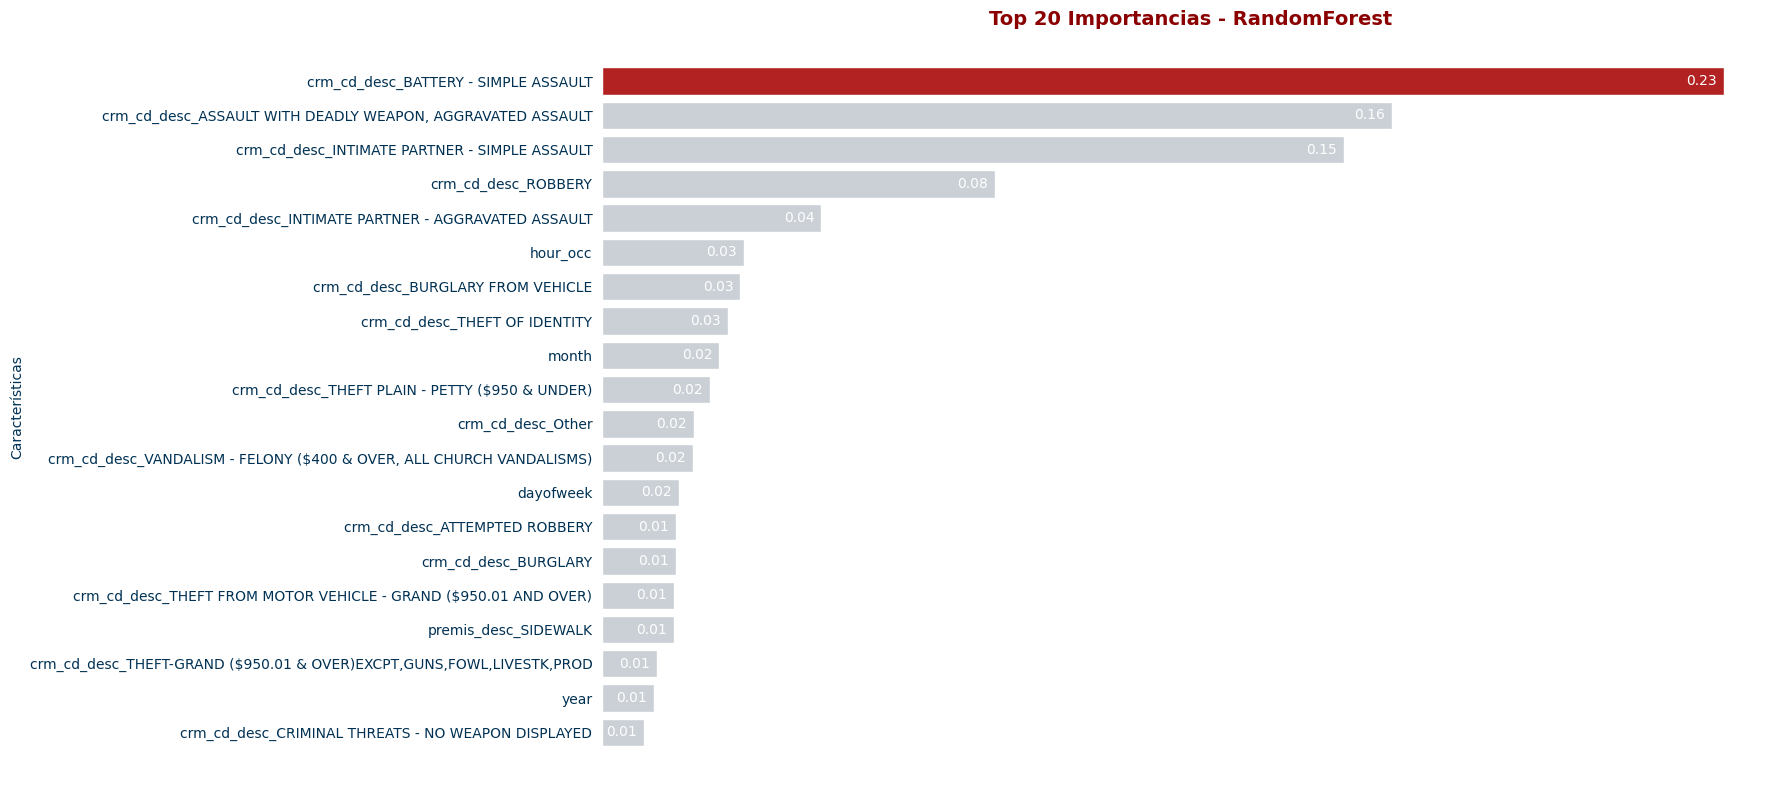

In [27]:
# Importancias (aprox) recuperando nombres
prep = pipe.named_steps["prep"]
ohe = prep.named_transformers_["cat"]
num_names = features_num
cat_basenames = [c for c in features_cat if c in ml.columns]
cat_names = list(ohe.get_feature_names_out(cat_basenames)) if cat_basenames else []
feat_names = np.array(num_names + cat_names)

try:
    importances = pipe.named_steps["rf"].feature_importances_
    idx = np.argsort(importances)[-20:][::-1]
    top_feats = pd.Series(importances[idx], index=feat_names[idx])
    # Orden ascendente: la más grande queda última y, en barh, aparece ARRIBA
    top_feats = top_feats.sort_values(ascending=True)

    bar_from_series(top_feats, title="Top 20 Importancias - RandomForest", xlabel="Importancia", ylabel="Características",
        style={"figsize": (18,8), "bar_orientation": "horizontal", "show_values": True, "value_inside": True, "value_rotation": "horizontal", "ylabels_visible": True, "highlight_max": True}
    )

    savefig("05_rf_importances.png"); plt.show(); plt.close()
except Exception:
    pass

In [28]:
# ============================================
# 6. NO SUPERVISADO: PCA + KMEANS
# ============================================
unsup_cols = [c for c in ["hour_occ","dayofweek","month","year"] if c in df_clean.columns]
unsup = df_clean[unsup_cols].dropna().copy()
if len(unsup) > 60_000:
    unsup = unsup.sample(60_000, random_state=RANDOM_STATE)

scaler = StandardScaler()
Z = scaler.fit_transform(unsup)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z2 = pca.fit_transform(Z)
print("PCA varianza explicada (2 comp):", pca.explained_variance_ratio_.sum())

PCA varianza explicada (2 comp): 0.5212249859152711


In [29]:
# K óptimo - Calcular inercia (curva del codo)
inertias = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, n_init="auto", random_state=RANDOM_STATE)
    km.fit(Z2)
    inertias.append(km.inertia_)

serie_codo = pd.Series(inertias, index=K)

# Calcular el codo automáticamente
# Línea recta entre primer y último punto
p1 = np.array([K[0], inertias[0]])
p2 = np.array([K[-1], inertias[-1]])

distancias = []
for i, (k, inertia) in enumerate(zip(K, inertias)):
    p = np.array([k, inertia])
    # distancia perpendicular a la recta p1-p2
    d = np.abs(np.cross(p2 - p1, p1 - p)) / np.linalg.norm(p2 - p1)
    distancias.append(d)

k_opt = K[np.argmax(distancias)]  # el k con mayor distancia al segmento

print(f"El codo se detecta en k = {k_opt}")


El codo se detecta en k = 4


[fig] outputs_crime_project/06_kmeans_elbow.png


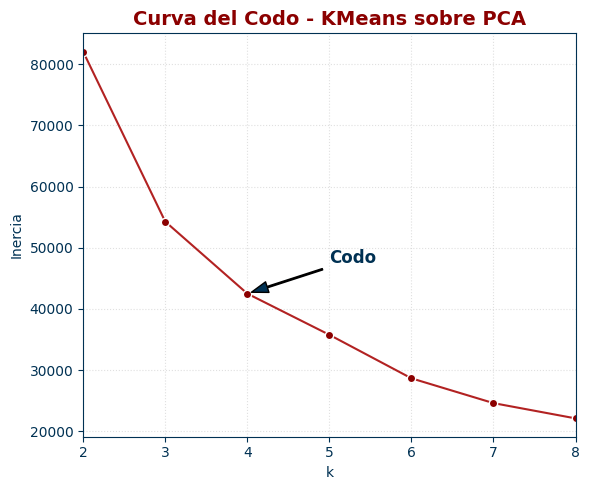

In [30]:
# Graficar con anotación automática
line_from_series(serie_codo, "Curva del Codo - KMeans sobre PCA", "k", "Inercia",
    style={"figsize": (6, 5), "hide_axes": False, "xlabels_visible": True, "ylabels_visible": True, "show_grid": True, "marker": "o"},
    annotate={"text": "Codo", "xy": (k_opt, serie_codo[k_opt]), "color": BRAND_COLORS["dark"]}
)

savefig("06_kmeans_elbow.png"); plt.show(); plt.close()

[fig] outputs_crime_project/06_pca_kmeans.png


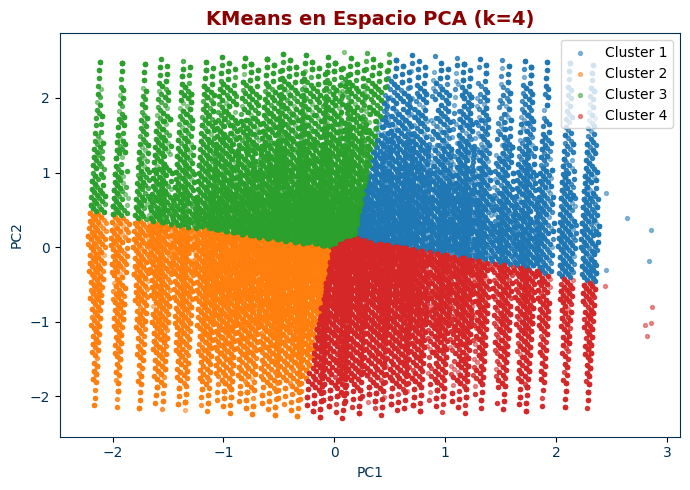

In [31]:
# KMeans
k_opt = 4
km = KMeans(n_clusters=k_opt, n_init="auto", random_state=RANDOM_STATE)
labels = km.fit_predict(Z2)

plt.figure(figsize=(7,5))
# Asignar color según label
for i in range(k_opt):
    plt.scatter(Z2[labels==i, 0], Z2[labels==i, 1], s=8, alpha=0.5, label=f"Cluster {i+1}")

# Título y ejes
plt.title(f"KMeans en Espacio PCA (k={k_opt})", color=BRAND_COLORS["accent"], fontsize=14, fontweight="bold")
plt.xlabel("PC1", color=BRAND_COLORS["dark"])
plt.ylabel("PC2", color=BRAND_COLORS["dark"])

# Ejes (tick labels y bordes)
plt.xticks(color=BRAND_COLORS["dark"])
plt.yticks(color=BRAND_COLORS["dark"])
for spine in plt.gca().spines.values():
    spine.set_color(BRAND_COLORS["dark"])

plt.legend()
plt.tight_layout()

savefig("06_pca_kmeans.png"); plt.show(); plt.close()

[fig] outputs_crime_project/07_ts_monthly.png


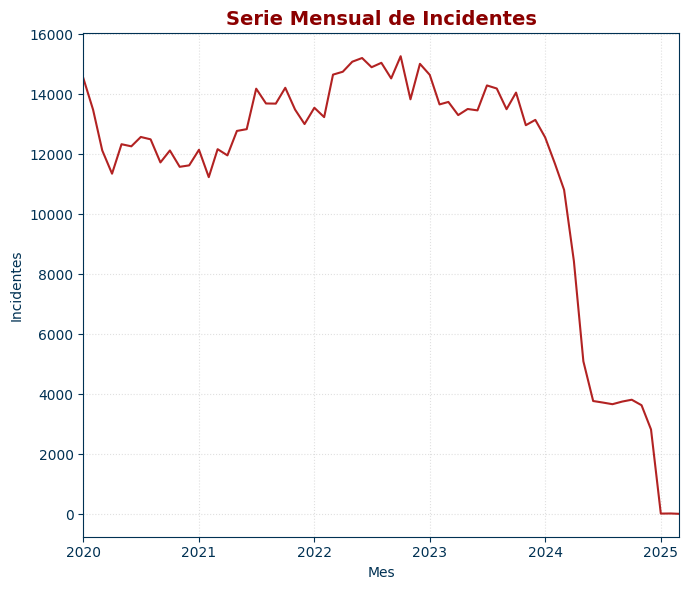

In [32]:
# ============================================
# 7. SERIES DE TIEMPO
# ============================================
# Column date_month
ts = df_clean.groupby("date_month").size().asfreq("MS").fillna(0)

# Gráficas ACF/PACF
line_from_series(ts, "Serie Mensual de Incidentes", "Mes", "Incidentes",
    style={"figsize": (7, 6), "hide_axes": False, "xlabels_visible": True, "ylabels_visible": True, "show_grid": True}
)
savefig("07_ts_monthly.png"); plt.show(); plt.close()


[fig] outputs_crime_project/07_ts_acf.png


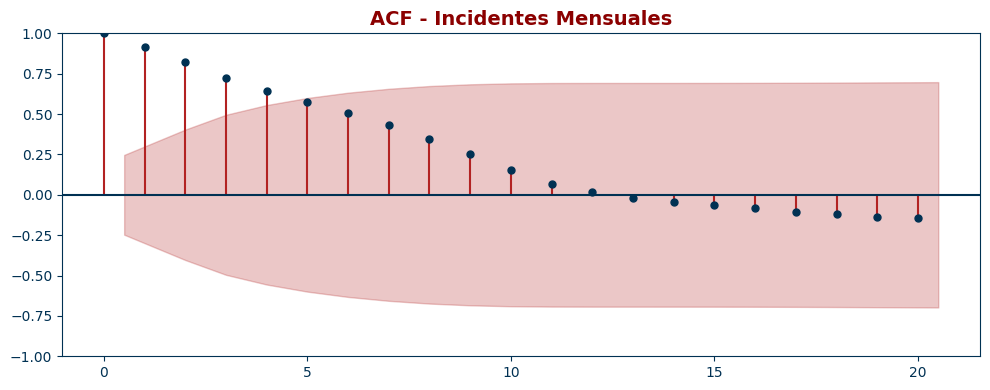

[fig] outputs_crime_project/07_ts_pacf.png


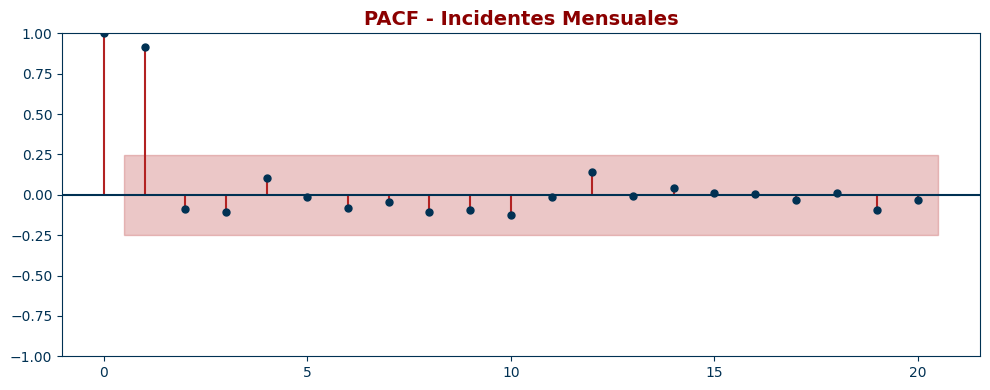

In [33]:
# Gráfica de Función de Autocorrelación - ACF
plot_custom_corr(ts, kind="acf", lags=20, title="ACF - Incidentes Mensuales")
savefig("07_ts_acf.png"); plt.show(); plt.close()

# Gráfica de Función de Función de Autocorrelación Parcial - PACF
plot_custom_corr(ts, kind="pacf", lags=20, title="PACF - Incidentes Mensuales")
savefig("07_ts_pacf.png"); plt.show(); plt.close()

In [34]:
# ============================================
# 8. DETECCIÓN DE ANOMALÍAS
# ============================================
anom_cols = [c for c in ["hour_occ","dayofweek","month","year"] if c in df_clean.columns]
anom = df_clean[anom_cols].dropna()
if len(anom) > 80_000:
    anom = anom.sample(80_000, random_state=RANDOM_STATE)

sc2 = StandardScaler()
A = sc2.fit_transform(anom)

iso = IsolationForest(contamination=0.02, n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
pred = iso.fit_predict(A)  # -1 outlier, 1 inlier
rate = (pred == -1).mean()
print(f"\n[Anomalías] Tasa estimada outliers: {rate:.2%}")

pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
A2 = pca2.fit_transform(A)



[Anomalías] Tasa estimada outliers: 1.99%


[fig] outputs_crime_project/08_anomalies_pca.png


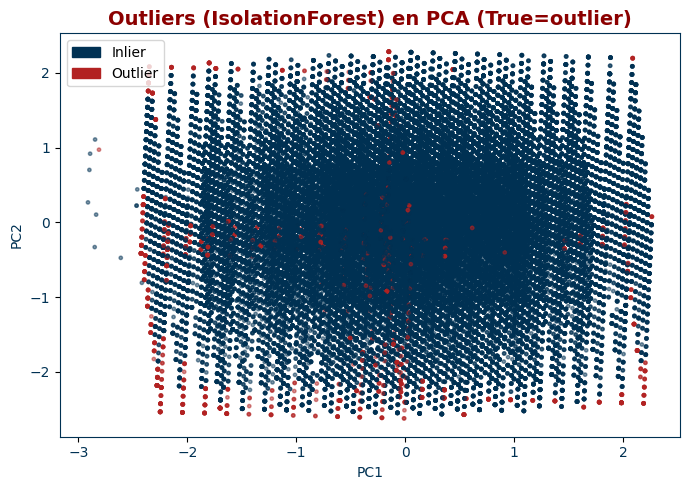

In [35]:
# Grafica de Outliers - Inliers
plt.figure(figsize=(7,5))
# Colormap personalizado: [False (inlier), True (outlier)]
cmap = ListedColormap([BRAND_COLORS["dark"], BRAND_COLORS["primary"]])
plt.scatter(A2[:,0], A2[:,1], s=6, alpha=0.5, c=(pred==-1), cmap=cmap)

# Título y ejes
plt.title(f"Outliers (IsolationForest) en PCA (True=outlier)", color=BRAND_COLORS["accent"], fontsize=14, fontweight="bold")
plt.xlabel("PC1", color=BRAND_COLORS["dark"])
plt.ylabel("PC2", color=BRAND_COLORS["dark"])

# Ejes (tick labels y bordes)
plt.xticks(color=BRAND_COLORS["dark"])
plt.yticks(color=BRAND_COLORS["dark"])
for spine in plt.gca().spines.values():
    spine.set_color(BRAND_COLORS["dark"])

# Leyenda manual
inlier_patch = mpatches.Patch(color=BRAND_COLORS["dark"], label="Inlier")
outlier_patch = mpatches.Patch(color=BRAND_COLORS["primary"], label="Outlier")
plt.legend(handles=[inlier_patch, outlier_patch])

plt.tight_layout()

savefig("08_anomalies_pca.png"); plt.show(); plt.close()


In [36]:
# ============================================
# 9. RESUMEN & ARTEFACTOS
# ============================================
summary = {
    "rows_original": len(df),
    "rows_clean": len(df_clean),
    "monthly_last_12_mean": float(df_clean.groupby("date_month").size().tail(12).mean()) if "date_month" in df_clean.columns else None,
    "rf_metrics": metrics,
    "pca_var_2": float(pca.explained_variance_ratio_.sum()) if 'pca' in locals() else None,
    "anomaly_rate": float(rate),
    "timestamp": datetime.utcnow().isoformat()+"Z"
}
with open(os.path.join(OUT, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n[Resumen del proyecto]")
print(json.dumps(summary, indent=2))
print(f"\nArtefactos guardados en: {OUT}")



[Resumen del proyecto]
{
  "rows_original": 1004991,
  "rows_clean": 716689,
  "monthly_last_12_mean": 3228.9166666666665,
  "rf_metrics": {
    "accuracy": 0.9673219941676318,
    "precision": 0.9648120367102012,
    "recall": 0.9340267395668703,
    "f1": 0.9491698317959848,
    "roc_auc": 0.9966567264270579
  },
  "pca_var_2": 0.5212249859152711,
  "anomaly_rate": 0.0199375,
  "timestamp": "2025-08-22T18:37:29.420382Z"
}

Artefactos guardados en: outputs_crime_project
